In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete
from scipy.optimize import curve_fit
from scipy.ndimage import  zoom
import warnings

In [63]:


def apparentBarrier(d, G, phi):
    return 0.5*G* np.exp(-1.025 *phi* d)

def stm_sim(u, h, x, dt, params): # estado da ponta de prova, sinal de entrada, altura da amostra, passo, parâmetros de configuração
    
    dx_dt = np.zeros(3)

    dx_dt[0] = x[1]
    dx_dt[1] =  (1/params['m'])*(params['d']*u -params['b_']*x[1] -params['a']*params['ki']*x[0] - (1-params['a'])*params['ki']*x[2])
    dx_dt[2] = x[1]*(params['alpha'] -(params['beta']*np.sign(x[2]*x[1])+params['gamma'])*np.abs(x[2])**params['n'])

    new_x = x + dt*dx_dt # Método de Euler 
    
    delta_z = params['offset'] - new_x[0] - h # distância da ponta de prova até a superfície

    current = params['sigma']*params['Vb']*np.exp(-1.025*np.sqrt(params['work_fn'])*delta_z)

    linearized_current = np.log(current)

    return linearized_current, delta_z, new_x


def stm_sim_image(u,image, a,b, x, dt, params): # estado da ponta de prova, sinal de entrada, altura da amostra, passo, parâmetros de configuração
    
    dx_dt = np.zeros(3)

    dx_dt[0] = x[1]
    dx_dt[1] =  (1/params['m'])*(params['d']*u -params['b_']*x[1] -params['a']*params['ki']*x[0] - (1-params['a'])*params['ki']*x[2])
    dx_dt[2] = 0 # x[1]*(params['alpha'] -(params['beta']*np.sign(x[2]*x[1])+params['gamma'])*np.abs(x[2])**params['n'])

    new_x = x + dt*dx_dt # Método de Euler 
    
    delta_z = params['offset'] - new_x[0] # distância da ponta de prova até a superfície

    max_point = 40 #np.argmax(image[a,b]) + 10
    height_factor = 0.06160614
    xs = np.arange(max_point,image.shape[-1], 1)*height_factor
    ys = image[a,b,max_point:]
    p0 = (1., 1.) # start with values near those we expect
    paramsB, cv = curve_fit(apparentBarrier, xs, ys, p0)

    G, phi = paramsB
    linearized_current = np.log(apparentBarrier(delta_z, G, phi))
    return linearized_current, delta_z, new_x

plant_params = {
                'sigma': 20, # Coeficiente de proporcionalidade da corrente de tunelamento
                'work_fn':4.7, # Função trabalho
                'Vb':.5, # Tensão de polarização
                'offset': 5., # distancia do piezo com relação a menor altura
                'm': .1, # Massa do piezo
                'b_': 5, # Coeficiente de viscosidade
                'a': .95, # Coeficiente de pós-escoamento
                'ki': 90, # rigidez
                'd': 90, # Coeficiente do piezo m/V

                # Constantes para medir o deslocamento inerente à histerese
                'alpha': 1, 
                'beta': 0.8,
                'gamma': 0.2,
                'n': 2,}

def generate_random_inputs(t):
    
    data = np.zeros_like(t)
    frequencies = np.array([1, 10, 50, 100, 150, 200, 250, 300, 400, 450, 500])
    phases = np.array([np.random.uniform(-np.pi/2, np.pi/2) for i in range(frequencies.shape[0])])
    amplitudes = np.array([1/frequencies[i] for i in range(frequencies.shape[0])])
    
    for k, _ in enumerate(frequencies):
        data += amplitudes[k]*np.sin(2*np.pi*frequencies[k]*t + phases[k])
    return data

In [79]:
final = 100
dt = 1e-3
t = np.arange(0, final, dt)
atom_radius = 3
n_atoms = 2*10
correction_constant = (atom_radius*n_atoms)/final
w = np.pi*n_atoms/final
h = np.sin(w*t)**2
#h[25000:] += 2*h[25000:]
mi = 1e-4
mi2 = 5e-5

K = 1
tau = .2
reference_model = cont2discrete(([K],[tau,1]), dt=dt, method='euler')
am = reference_model[0].squeeze()
bm = -reference_model[1].squeeze() # inverter por conta da forma do filtro IIR: 1 - b0 - b1 - ... - bn

xd = np.zeros_like(t) + np.log(1.)# + 0.005*np.random.uniform(-1, 1, len(t))
y_stm_past = 0
xm = np.zeros_like(am)
ym = np.zeros_like(bm)

y_ref = np.zeros_like(t)



a_plant = np.zeros(3)
b_plant = np.zeros(2)
bias_plant = 0


x_plant = np.zeros_like(a_plant)
y_plant = np.zeros_like(b_plant)

x_plant_copy = np.zeros_like(a_plant)
y_plant_copy = np.zeros_like(b_plant)

a_control = np.zeros(3)
b_control = np.zeros(2)
bias_control = 0

x_control = np.zeros_like(a_control)
y_control = np.zeros_like(b_control)
x_control_train = np.zeros_like(a_control)


y_pred = np.zeros_like(t)
y_pred_2 = np.zeros_like(t)
y_pred_control = np.zeros_like(t)
y_stm = np.zeros_like(t)
z_stm = np.zeros_like(t)
e1 = np.zeros_like(t)
e2 = np.zeros_like(t)
states = np.zeros(3)
delta_z_list = np.zeros_like(t)

a_plant_list = np.zeros((3, len(t)))
b_plant_list = np.zeros((2, len(t)))
bias_plant_list = np.zeros(len(t))

a_control_list = np.zeros((3, len(t)))
b_control_list = np.zeros((2, len(t)))
bias_control_list = np.zeros(len(t))



In [80]:
for i, k in enumerate(t):
    
    if i == 0:
        y_stm[i], delta_z_list[i], states = stm_sim(0, h[i] , states, dt,plant_params)
        states = np.zeros(3)
        e1[i] = y_pred[i] - y_stm[i]
    else:
        y_stm[i], delta_z_list[i], states = stm_sim(y_pred_control[i-1], h[i], states, dt,plant_params)
        #y_stm[i] += 0.0005*np.random.uniform(-1, 1, 1)
        x_plant = np.roll(x_plant, 1)
        x_plant[0] = y_pred_control[i-1]
        z_stm[i] = states[0]

        y_plant = np.roll(y_plant, 1)
        y_plant[0] = np.dot(a_plant, x_plant) + np.dot(b_plant[1:], y_plant[1:]) + bias_plant
        y_pred[i] = y_plant[0]

        e1[i] = y_pred[i] - y_stm[i]

        a_plant = a_plant - 2*mi*e1[i]*x_plant
        b_plant[1:] = b_plant[1:] - 2*mi*e1[i]*y_plant[1:]
        bias_plant = bias_plant - 2*mi*e1[i]

    
    xm = np.roll(xm,1)
    xm[0] = xd[i]
    ym = np.roll(ym,1)
    if i == 0:
        ym[0] = y_stm[i]
    else:
        ym[0] = np.dot(am, xm) + np.dot(bm[1:], ym[1:])

    
    y_ref[i] = ym[0] # Saída  do modelo de referência
    
    x_plant_copy = np.roll(x_plant_copy, 1)
    x_plant_copy[0] = xd[i]

    y_plant_copy = np.roll(y_plant_copy, 1)
    y_plant_copy[0] = np.dot(a_plant, x_plant_copy) + np.dot(b_plant[1:], y_plant_copy[1:])+ bias_plant
    y_pred_2[i] = y_plant_copy[0]

    x_control_train = np.roll(x_control_train, 1)
    x_control_train[0] = y_pred_2[i]

    x_control = np.roll(x_control, 1)
    x_control[0] = xd[i]

    y_control = np.roll(y_control, 1)
    y_control[0] = np.dot(a_control, x_control) + np.dot(b_control[1:], y_control[1:]) + bias_control
    y_pred_control[i] = y_control[0] 

    e2[i] = y_stm[i] - y_ref[i]

    a_control = a_control - 2*mi2*e2[i]*x_control_train
    b_control[1:] = b_control[1:] - 2*mi2*e2[i]*y_control[1:]
    bias_control = bias_control - 2*mi2*e2[i]


    for j in range(len(a_plant)):
        a_plant_list[j, i] = a_plant[j]
    
    for j in range(len(b_plant)):
        b_plant_list[j, i] = b_plant[j]

    bias_plant_list[i] = bias_plant

    for j in range(len(a_control)):
        a_control_list[j, i] = a_control[j]
    
    for j in range(len(b_control)):
        b_control_list[j, i] = b_control[j]

    bias_control_list[i] = bias_control
    

    

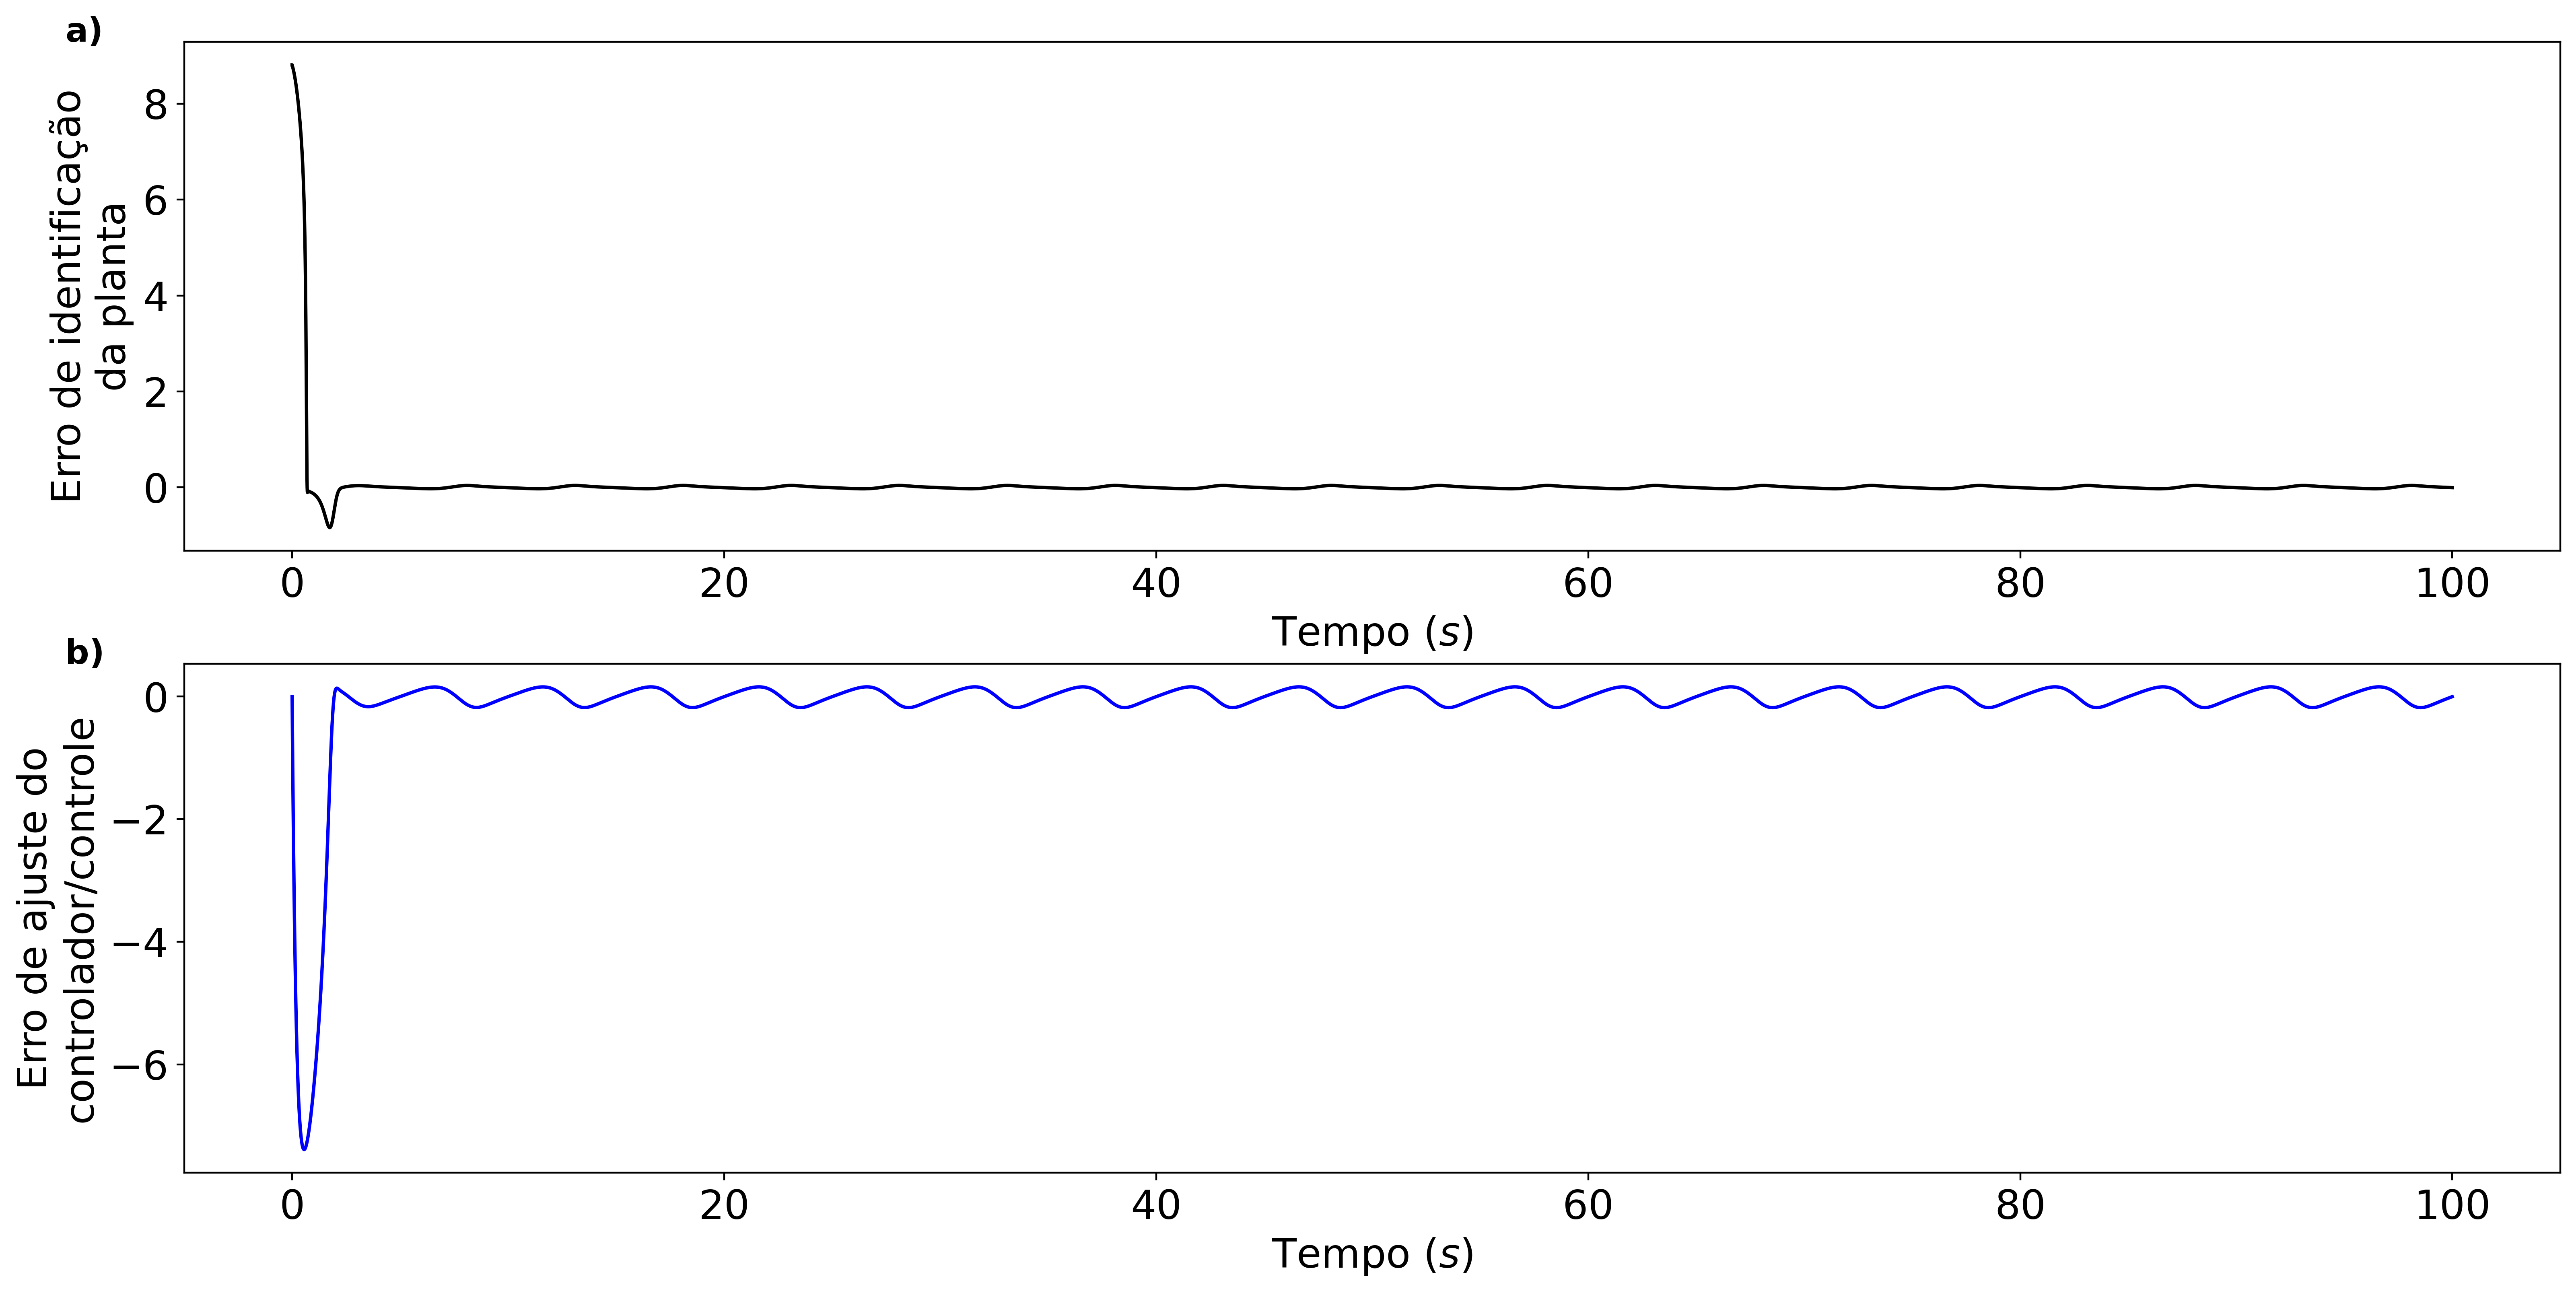

In [81]:
import matplotlib.pyplot as plt
import string

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(2,1)
fig.set_size_inches(16, 8)
fig.tight_layout()
fig.dpi = 400





axs[0].set_ylabel("Erro de identificação\nda planta")
axs[0].set_xlabel("Tempo ($s$)")
axs[0].plot(t, e1, 'k')

axs[1].set_ylabel("Erro de ajuste do\ncontrolador/controle")
axs[1].set_xlabel("Tempo ($s$)")
axs[1].plot(t, e2, 'b')



for n, ax in enumerate(axs):
    ax.text(-0.05, 1, f'{string.ascii_lowercase[n]})', transform=ax.transAxes, size=15, weight='bold')
plt.show()

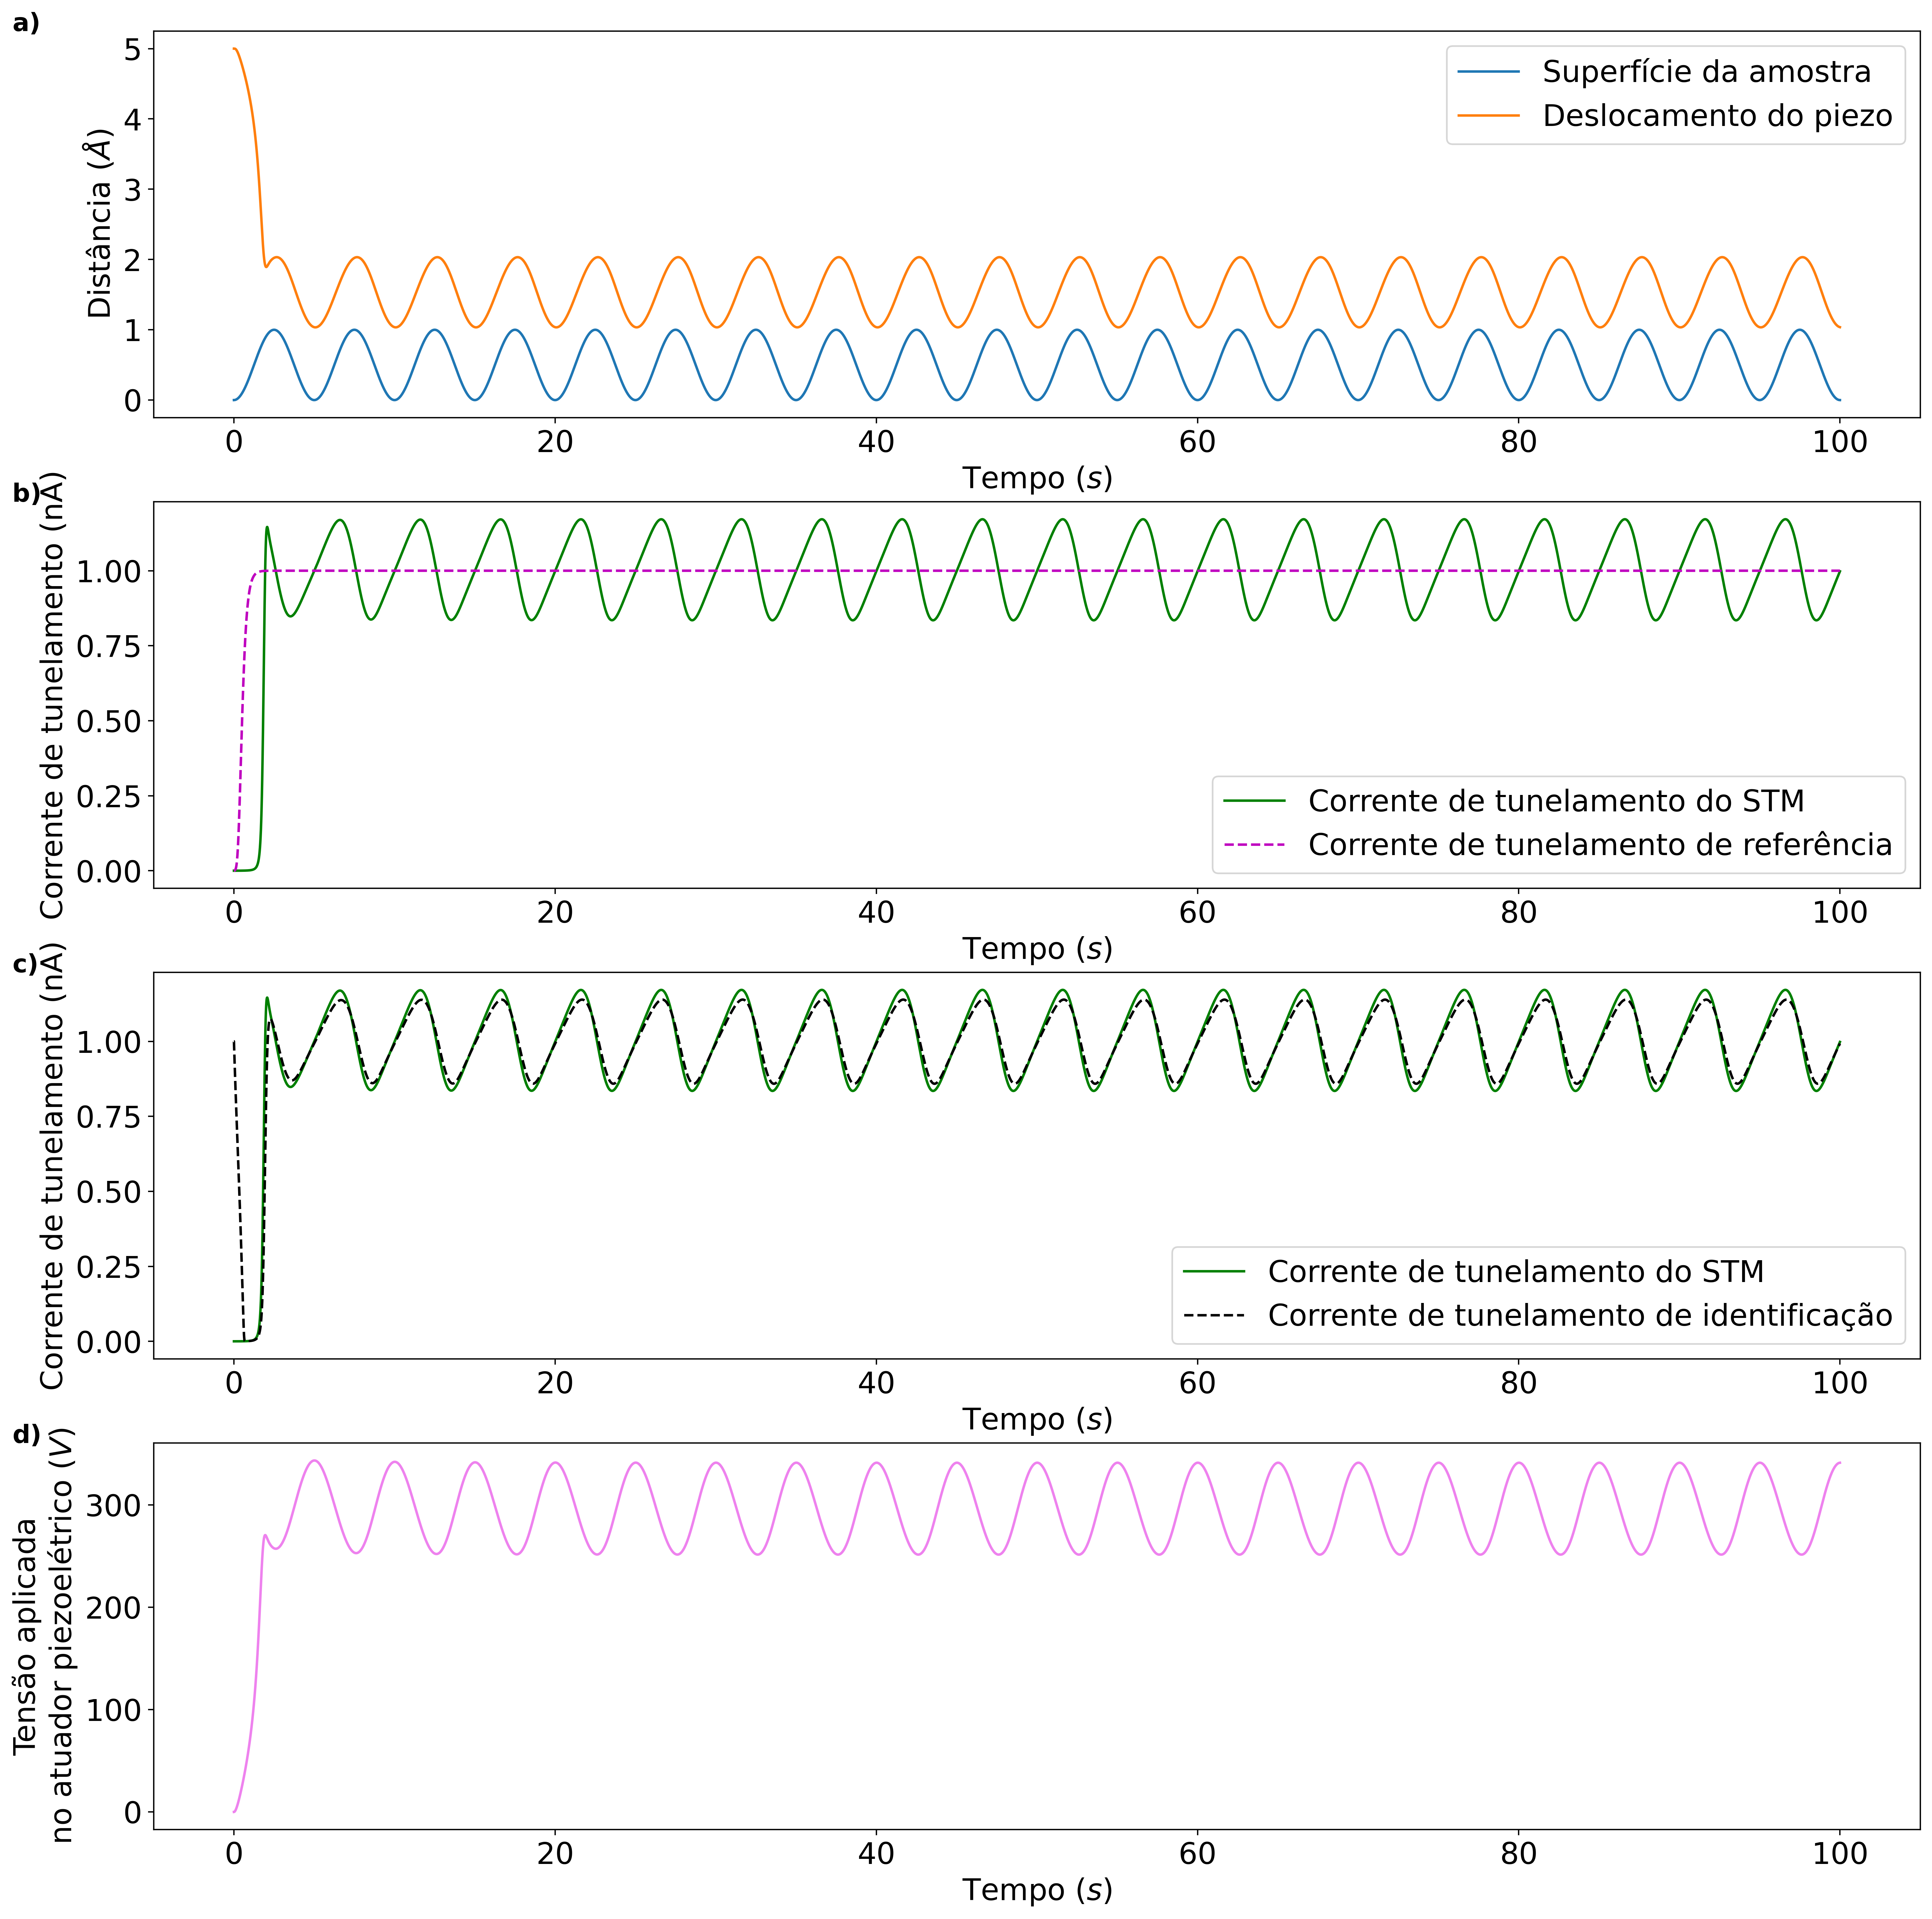

In [88]:
import matplotlib.pyplot as plt
import string

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(4,1)
fig.set_size_inches(16, 16)
fig.tight_layout()
fig.dpi = 400



axs[0].set_ylabel("Distância ($\AA$)")
axs[0].set_xlabel("Tempo ($s$)")
axs[0].plot(t, h, t, h+ delta_z_list)
axs[0].legend(["Superfície da amostra", "Deslocamento do piezo"])


axs[1].set_ylabel("Corrente de tunelamento (nA)")
axs[1].set_xlabel("Tempo ($s$)")
axs[1].plot(t, np.exp(y_stm), 'g', t, np.exp(y_ref),'m--')
axs[1].legend(["Corrente de tunelamento do STM", "Corrente de tunelamento de referência"])

axs[2].set_ylabel("Corrente de tunelamento (nA)")
axs[2].set_xlabel("Tempo ($s$)")
axs[2].plot(t, np.exp(y_stm), 'g', t, np.exp(y_pred),'k--')
axs[2].legend(["Corrente de tunelamento do STM", "Corrente de tunelamento de identificação"])

axs[3].set_ylabel("Tensão aplicada\nno atuador piezoelétrico ($V$)")
axs[3].set_xlabel("Tempo ($s$)")
axs[3].plot(t, plant_params['d']*y_pred_control, 'violet')

for n, ax in enumerate(axs):
    ax.text(-0.08, 1, f'{string.ascii_lowercase[n]})', transform=ax.transAxes, size=15, weight='bold')
plt.show()

[]

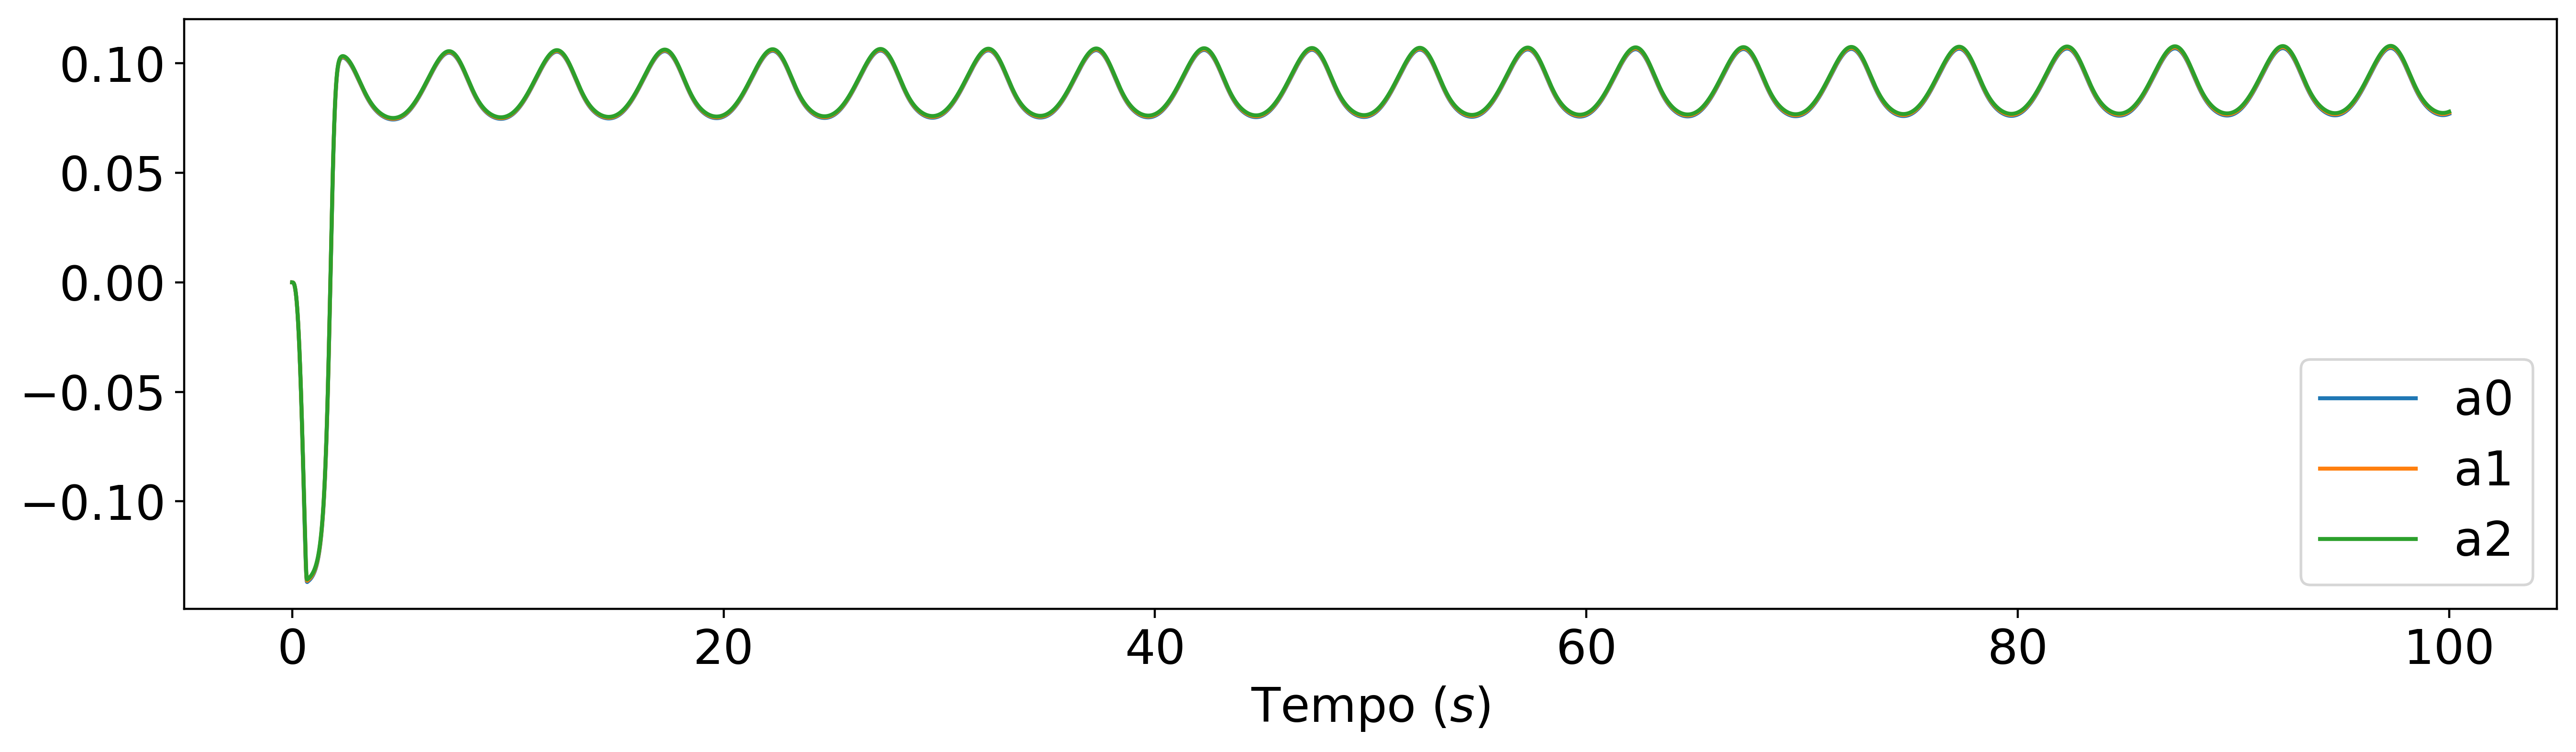

In [89]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(16, 4), dpi=400)
for i in range(len(a_plant_list)):
    plt.plot(t, a_plant_list[i])
plt.legend([f'a{i}' for i in range(len(a_plant_list))])
plt.xlabel("Tempo ($s$)")
plt.plot()

[]

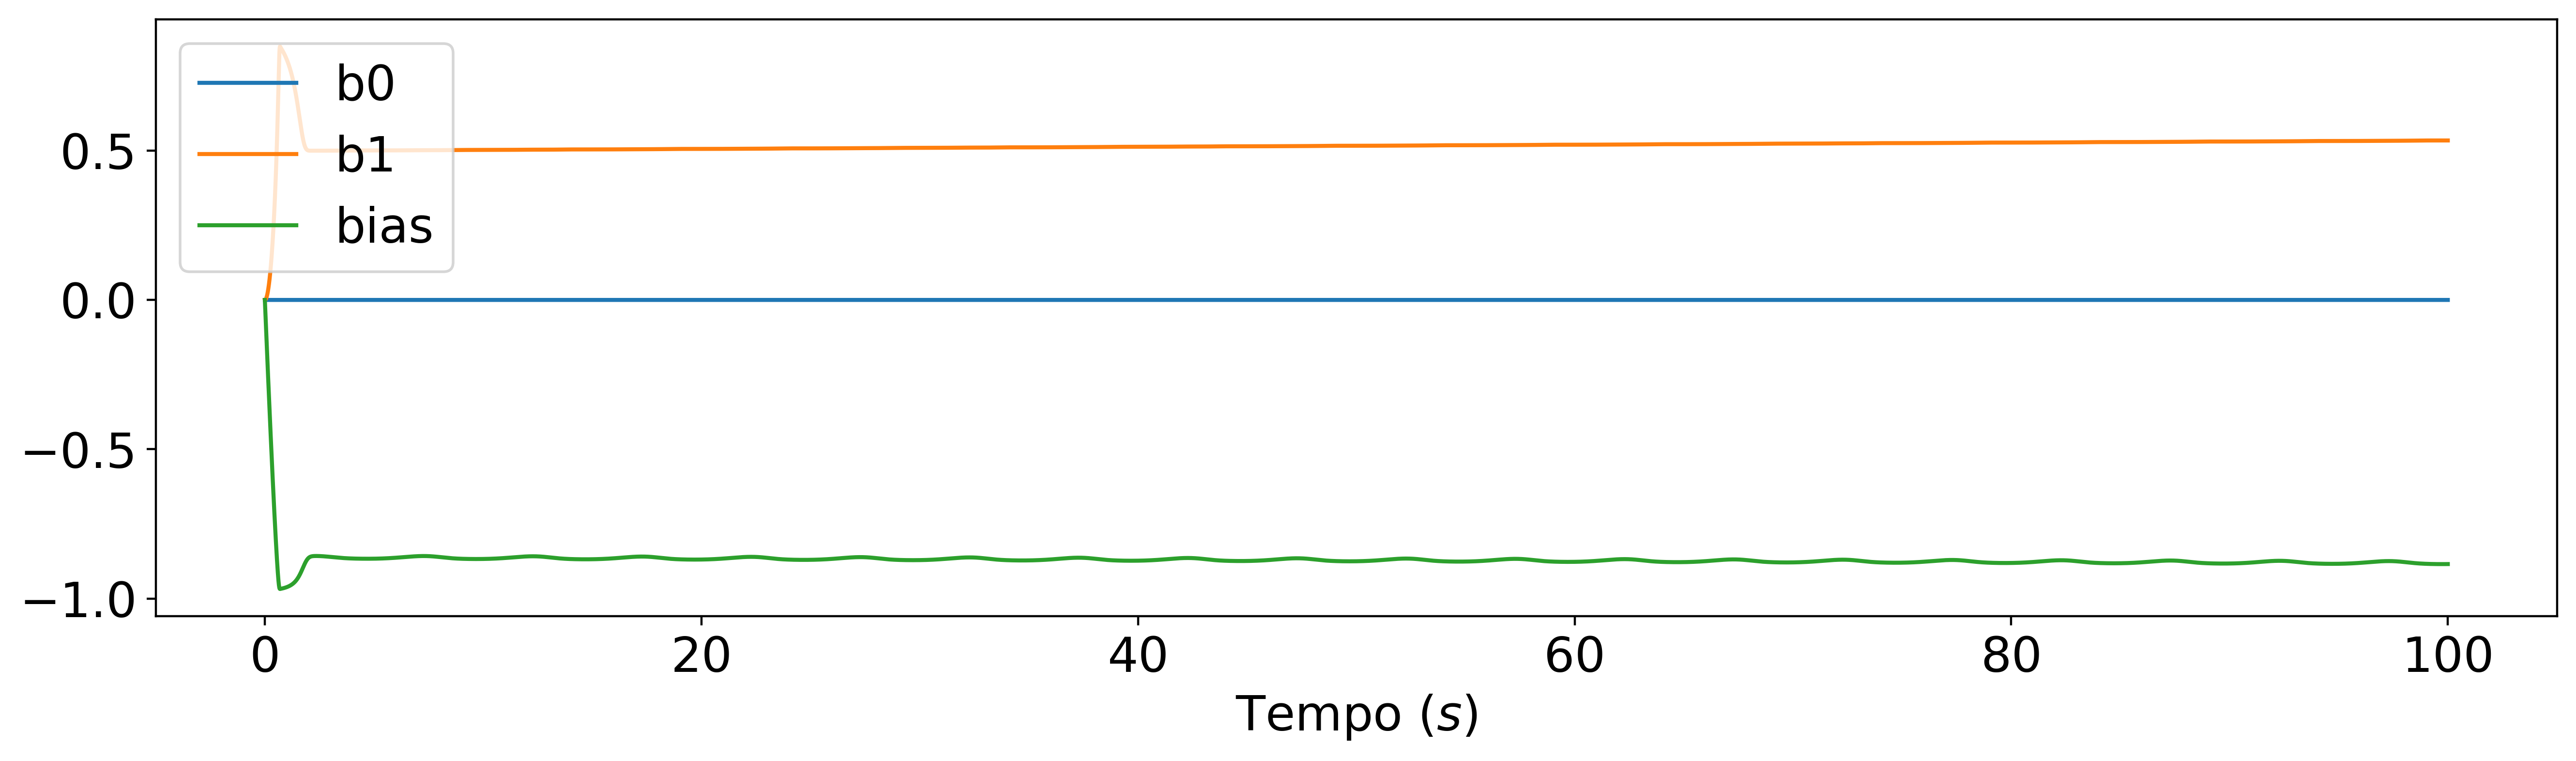

In [90]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(16, 4), dpi=400)
for i in range(len(b_plant_list)):
    plt.plot(t, b_plant_list[i])
plt.plot(t, bias_plant_list)
plt.legend([f'b{i}' for i in range(len(b_plant_list))]+ ['bias'])
plt.xlabel("Tempo ($s$)")
plt.plot()


[]

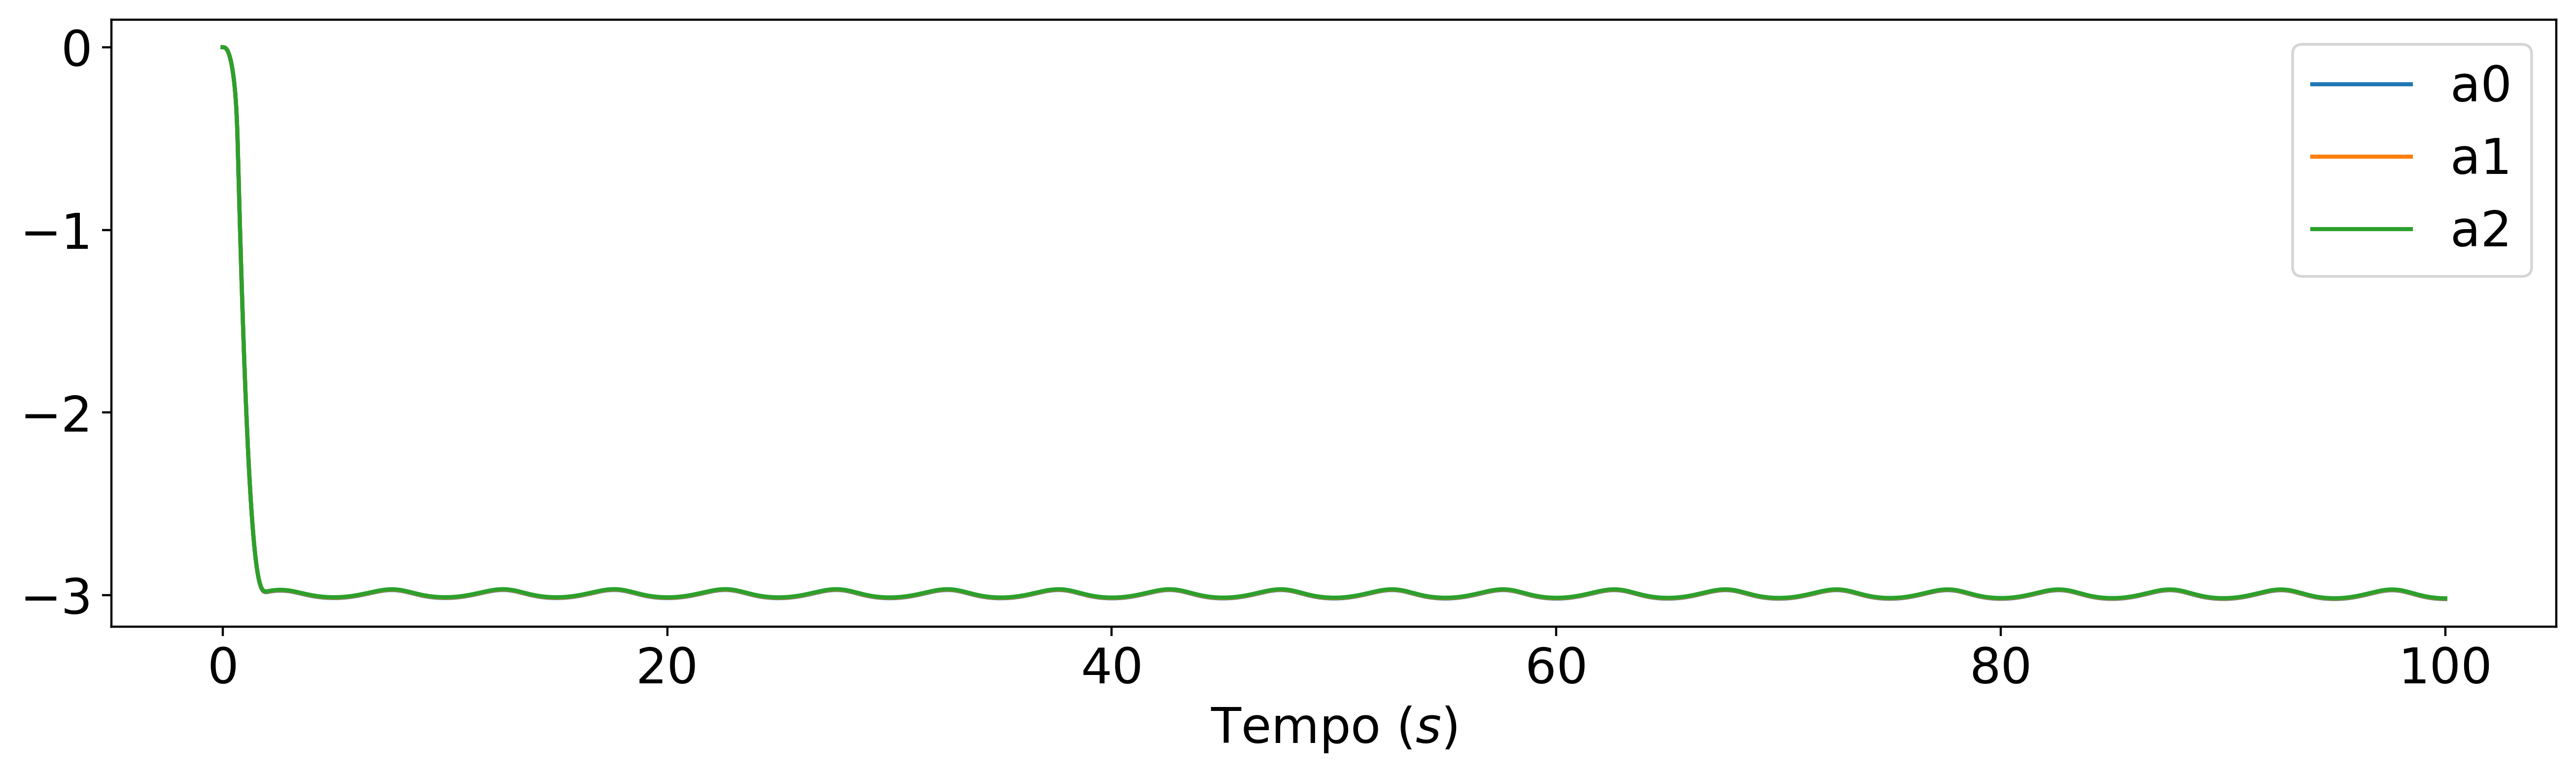

In [91]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(16, 4), dpi=400)
for i in range(len(a_control_list)):
    plt.plot(t, a_control_list[i])
plt.legend([f'a{i}' for i in range(len(a_control_list))])
plt.xlabel("Tempo ($s$)")
plt.plot()

[]

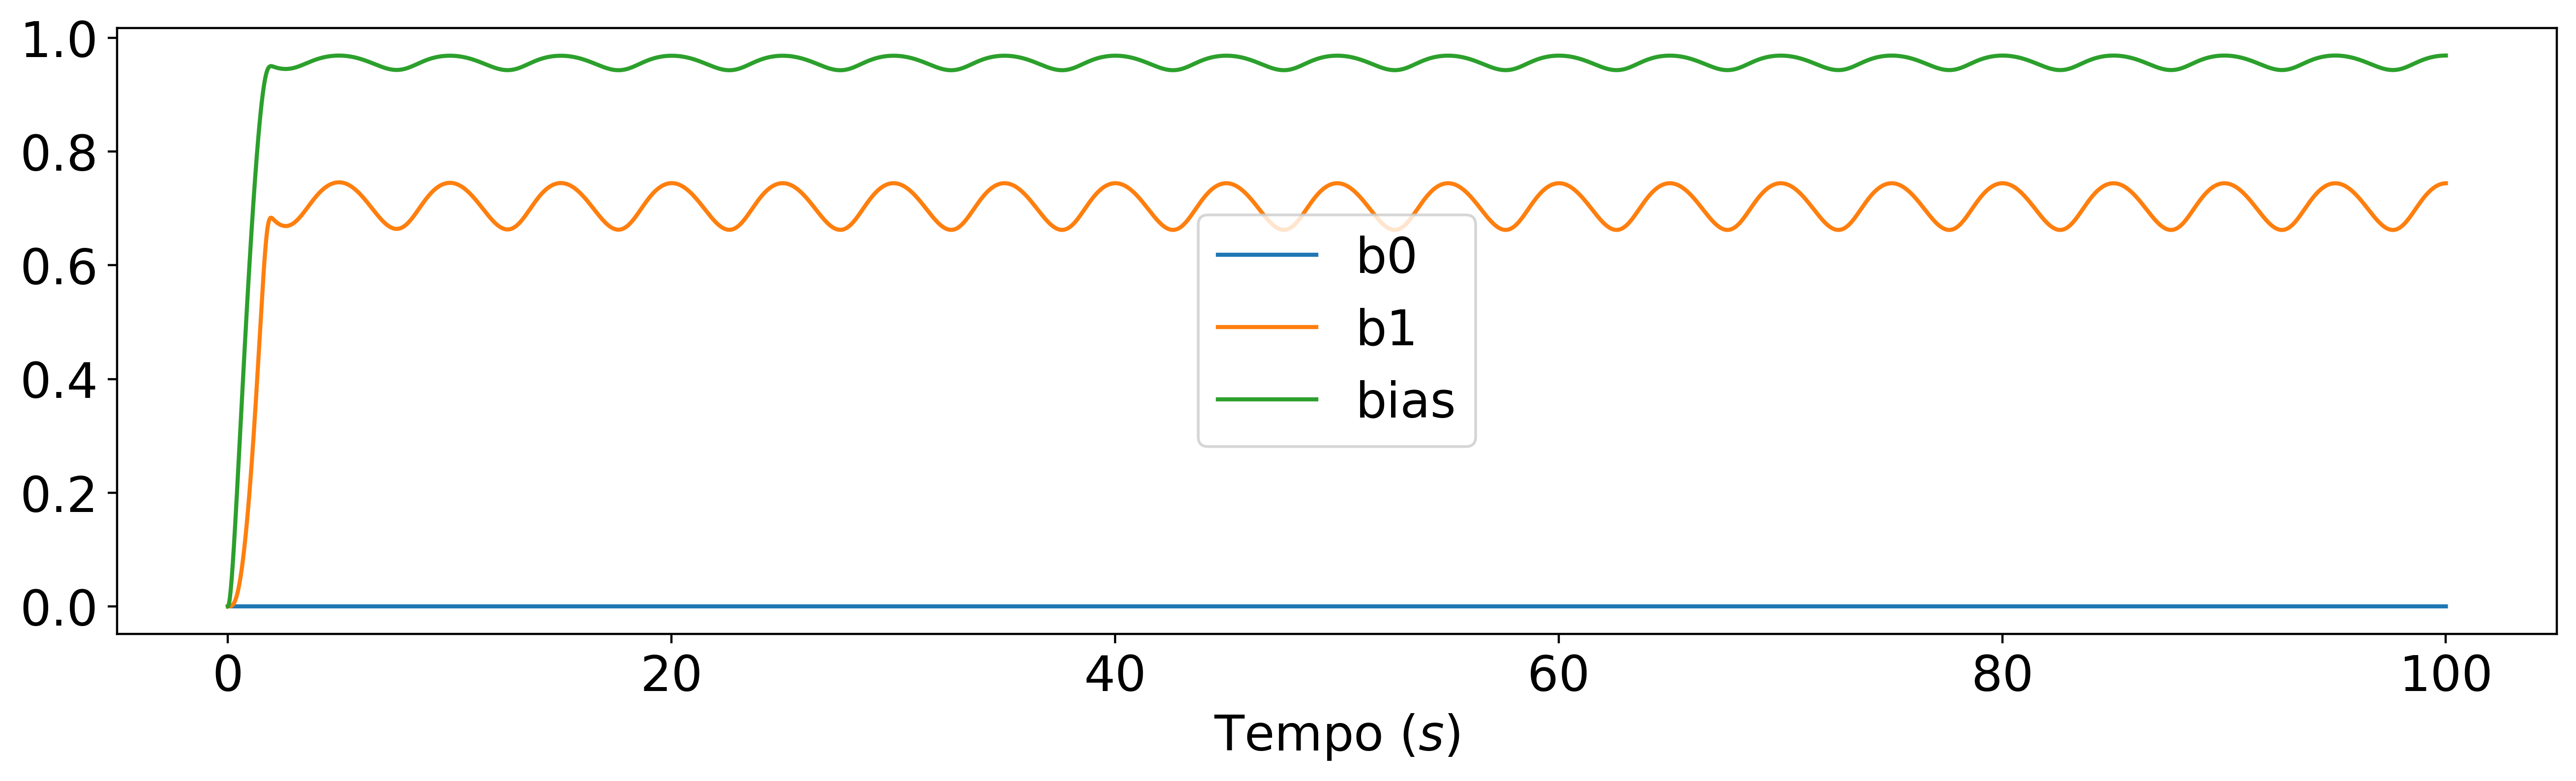

In [92]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(16, 4), dpi=400)
for i in range(len(b_control_list)):
    plt.plot(t, b_control_list[i])
plt.plot(t, bias_control_list)
plt.legend([f'b{i}' for i in range(len(b_control_list))]+ ['bias'])
plt.xlabel("Tempo ($s$)")
plt.plot()
